# Navier-Stokes Forward Simulation with Φ<sub>Flow</sub>

... now a more complex example with fluid simulations (Navier-Stokes) ... still very simple with phiflow (complexity of the differentiable operators hidden).

As before, the first command with a "!" prefix installs the [Φ<sub>Flow</sub> Python package from GitHub](https://github.com/tum-pbs/PhiFlow) via `pip` in your python environment. (Skip or modify this command if necessary.)

In [1]:
!pip install --upgrade --quiet phiflow
from phi.flow import *  # The Dash GUI is not supported on Google Colab, ignore the warning
import pylab

/home/thuerey/anaconda3/envs/tf/lib/python3.8/_collections_abc.py:743: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  for key in self._mapping:
/home/thuerey/anaconda3/envs/tf/lib/python3.8/_collections_abc.py:744: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  yield (key, self._mapping[key])
/home/thuerey/phiflow/phi/viz/display.py:80: UserWarning: GUI is disabled because of missing dependencies: No module named 'imageio'. To install all dependencies, run $ pip install phiflow[gui]
  warnings.warn('GUI is disabled because of missing dependencies: %s. To install all dependencies, run $ pip install phiflow[gui]' % import_error)


## Setting up the simulation

Φ<sub>Flow</sub> is object-oriented, i.e. you assemble your simulation by constructing a number of objects and adding them to the world.

The following code sets up four fluid simulations that run in parallel (`batch_size=4`). Each fluid simulation has a circular Inflow at a different location.

In [2]:
world = World()
fluid = world.add(Fluid(Domain([40, 32], boundaries=CLOSED), buoyancy_factor=0.05), physics=IncompressibleFlow())
world.add(Inflow(Sphere(center=[5,14], radius=3), rate=0.2));

The inflow affects the fluid's marker density. Because a Boussinesq model with a positive `buoyancy_factor` is active, the marker field `density` creates an upward force. Note that this density is not the density of the fluid, but the amount of marker quantity present in each cell.

Let's plot the marker density after one simulation frame.

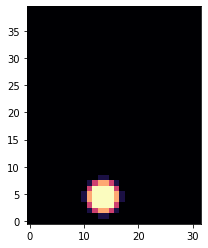

In [3]:
world.step()
pylab.imshow(fluid.density.data[0,...,0], origin='lower', cmap='magma')

A lot has happened internally in the `world.step()` call, e.g., for fluids we have a more complex `struct` object that stores the different fields of the simulation. For fluids we have the aforementioned marker density in addition to a velocity.

In [8]:
print("Fluid state: " + format(fluid.state))
print("\nVelocity content:")
[print(grid.data.shape) for grid in fluid.velocity.unstack()];

Fluid state: Fluid[density: Grid[40x32(1), size=[40. 32.], float32], velocity: StaggeredGrid[40x32, size=[40. 32.], float32]]

 Velocity content:
(1, 41, 32, 1)
(1, 40, 33, 1)


Note that we actually created two variables, one for each velocity component. If you're interested in how this  works, have a look at the [Struct documentation](https://github.com/tum-pbs/PhiFlow/blob/master/documentation/Structs.ipynb).

If you look closely at the output from the last `print` command, you'll notice that the shapes of the variables differ. This is because the velocity is sampled in [staggered form](https://github.com/tum-pbs/PhiFlow/blob/master/documentation/Staggered_Grids.md).


We can run more steps by repeatedly calling `world.step()`.

In [5]:
for frame in range(10):
  print('Computing frame %d' % frame)
  world.step(dt=1.5)

Computing frame 0
Computing frame 1
Computing frame 2
Computing frame 3
Computing frame 4
Computing frame 5
Computing frame 6
Computing frame 7
Computing frame 8
Computing frame 9


Now the hot plume is starting to rise:

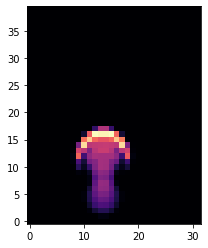

In [6]:
pylab.imshow(fluid.density.data[0,...,0], origin='lower', cmap='magma')

Let's compute and show a few more steps of the simulation.

Computing frame 0
Computing frame 1
Computing frame 2
Computing frame 3
Computing frame 4
Computing frame 5
Computing frame 6
Computing frame 7
Computing frame 8
Computing frame 9
Computing frame 10
Computing frame 11
Computing frame 12
Computing frame 13
Computing frame 14
Computing frame 15
Computing frame 16
Computing frame 17
Computing frame 18
Computing frame 19


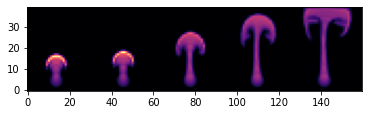

In [7]:
frames = [fluid.density.data[0,...,0]]
for frame in range(20):
  print('Computing frame %d' % frame)
  world.step(dt=1.5)
  if frame%5==0:
    frames.append(fluid.density.data[0,...,0])

pylab.imshow(np.concatenate(frames,axis=1), origin='lower', cmap='magma')

It looks simple here, but this is a powerful tool. The simulation could easily be extended to more complex cases or 3D, and they're fully compatible with back-propagation pipelines of deep learning frameworks. 

In the next chapters we'll show how to use these simulations for training NNs, and how to steer and modify them via trained NNs. This will illustrate how much we can improve the training process by having a solver in the loop, and especially by having differentiable solvers.